In [237]:
import ceviche_challenges
from ceviche_challenges import units as u
from ceviche_challenges.model_base import _wavelengths_nm_to_omegas

from ceviche import viz, fdfd_ez
from ceviche import jacobian

import autograd
import autograd.numpy as npa
import jax
import jax.numpy as jnp

import numpy as np
import matplotlib.pyplot as plt

In [238]:
from inverse_design.brushes import notched_square_brush, circular_brush
from inverse_design.conditional_generator import (
    new_latent_design, transform
)
from tqdm.notebook import trange

from javiche import jaxit

from inverse_design.local_generator import generate_feasible_design_mask
from jax.example_libraries.optimizers import adam

# Define the problem using ceviche_challenges

In [239]:
spec = ceviche_challenges.waveguide_bend.prefabs.waveguide_bend_2umx2um_spec(
    wg_width=400*u.nm, variable_region_size=(1600*u.nm, 1600*u.nm), cladding_permittivity=2.25
)
params = ceviche_challenges.waveguide_bend.prefabs.waveguide_bend_sim_params(resolution = 10 * u.nm,
                                                                             wavelengths=u.Array([1280,], u.nm))
                                                                             #wavelengths=u.Array([1270, 1290], u.nm))
model = ceviche_challenges.waveguide_bend.model.WaveguideBendModel(params, spec)

# Define the optimization function

In [240]:
def db_to_au(x):
    return npa.power(10, x / 10)

S_cutoff_dB = npa.array([-20., -0.5])
S_cutoff = db_to_au(S_cutoff_dB)
g = npa.array([-1 if x < S_cutoff.max() else +1 for x in S_cutoff])
w_valid = npa.array([x if x < S_cutoff.max() else 1-x for x in S_cutoff])

min_w = jnp.min(w_valid)

In [241]:
def plot_state(model, rho, grads):
    des = forward(rho, brush)
    
    _, E_12 = model.simulate(des, excite_port_idxs=[0])
    _, E_21 = model.simulate(des, excite_port_idxs=[1])

    E_12 = E_12.squeeze()
    E_21 = E_21.squeeze()
    
    fig, ax = plt.subplots(1,5, figsize=(5*4,4))
    viz.abs(E_12, outline=model.density(des), ax=ax[0]);
    viz.abs(E_21, outline=model.density(des), ax=ax[1]);
    viz.real(grads, ax=ax[2]);
    ax[3].imshow(grads.T)
    #viz.real(ez_in * np.conj(ez_out), outline=model.density(np.asarray(design)), ax=ax[2]);
    #viz.real(ez_in * ez_out, outline=model.density(np.asarray(design)), ax=ax[3]);
    #viz.real((Ez_source.squeeze() * Ez_probe.squeeze()).T, outline=model.density(np.asarray(design)), ax=ax[4]);
    plt.show()

In [242]:
rho = jnp.ones(model.design_region_shape)
s_params, fields = model.simulate(rho)

In [243]:
s_params, s_params.shape

(array([[[-0.20480596-0.21891126j, -0.07551151+0.00037407j]]]), (1, 1, 2))

In [244]:
loss_function(s_params)

Array(253.30588, dtype=float32)

In [245]:
@jaxit()
def objective_S(rho):
    s_params, fields = model.simulate(rho)
    
    return s_params

def loss_function(S):
    s11 = jnp.abs(S[:, 0, 0])**2
    s21 = jnp.abs(S[:, 0, 1])**2

    s = jnp.stack((s11,s21))
    g = jnp.stack((jnp.ones_like(s11),-jnp.ones_like(s21)))

    t_s21 = 10**(-0.5/20)
    t_s11 = 10**(-20/20)

    target = jnp.stack((jnp.ones_like(s11)*(t_s11**2),jnp.ones_like(s21)*(t_s21**2)))
    w_min = min(1-t_s21, t_s11)
    L = jnp.sum(jax.nn.softplus(g*(s-target)/w_min)**2)
    
    return L

In [246]:
print(loss_function(s_params))
if s_params.shape[0] > 1:
    print(loss_function(jnp.expand_dims(s_params[0],axis=0)) + loss_function(jnp.expand_dims(s_params[1],axis=0)))

253.30588


# Then, the inverse design aka the conditional generator part

In [247]:
def forward(latent_weights, brush):
    latent_t = transform(latent_weights, brush) #.reshape((Nx, Ny))
    design_mask = generate_feasible_design_mask(latent_t, 
      brush, verbose=False)
    design = (design_mask+1.0)/2.0
    return design

In [248]:
brush = circular_brush(11)
latent = new_latent_design(model.design_variable_shape, bias=0.95, r=1, r_scale=1e-3)

In [249]:
def loss_fn(latent):
    design = forward(latent, brush)
    S = objective_S(design)
    return loss_function(S)

In [250]:
def loss_no_gen(design):
    S = objective_S(design)
    return loss_function(S)
loss_fn = loss_no_gen

# Now we define the optimization

In [251]:
# Number of epochs in the optimization
Nsteps = 150
# Parameters for the Adam optimizer
step_size = 0.01
beta1 = 0.667
beta2 = 0.9

In [252]:
grad_fn = jax.grad(loss_fn)

init_fn, update_fn, params_fn = adam(step_size, beta1, beta2)
state = init_fn(latent) #.flatten()
#value_and_grad seems to have a problem. Figure out why!

def step_fn(step, state):
    latent = params_fn(state) # we need autograd arrays here...
    grads = grad_fn(latent)
    loss = loss_fn(latent)

    optim_state = update_fn(step, grads, state)
    # optim_latent = params_fn(optim_state)
    # optim_latent = optim_latent/optim_latent.std()
    # plot_state(model, latent, grads)
    
    return loss, optim_state

In [253]:
init_fn, update_fn, params_fn = adam(step_size, beta1, beta2)
state = init_fn(npa.array(latent))

latent = params_fn(state)
grads = grad_fn(jnp.array(latent))

  0%|          | 0/150 [00:00<?, ?it/s]

Step : 1 / 150
Step : 2 / 150
Step : 3 / 150
Step : 4 / 150
Step : 5 / 150
Step : 6 / 150
Step : 7 / 150
Step : 8 / 150
Step : 9 / 150
Step : 10 / 150
Step : 11 / 150
Step : 12 / 150
Step : 13 / 150
Step : 14 / 150
Step : 15 / 150
Step : 16 / 150
Step : 17 / 150
Step : 18 / 150
Step : 19 / 150
Step : 20 / 150
Step : 21 / 150
Step : 22 / 150
Step : 23 / 150
Step : 24 / 150
Step : 25 / 150
Step : 26 / 150
Step : 27 / 150
Step : 28 / 150
Step : 29 / 150
Step : 30 / 150
Step : 31 / 150
Step : 32 / 150
Step : 33 / 150
Step : 34 / 150
Step : 35 / 150
Step : 36 / 150
Step : 37 / 150
Step : 38 / 150
Step : 39 / 150
Step : 40 / 150
Step : 41 / 150
Step : 42 / 150
Step : 43 / 150
Step : 44 / 150
Step : 45 / 150
Step : 46 / 150
Step : 47 / 150
Step : 48 / 150
Step : 49 / 150
Step : 50 / 150
Step : 51 / 150
Step : 52 / 150
Step : 53 / 150
Step : 54 / 150
Step : 55 / 150
Step : 56 / 150
Step : 57 / 150
Step : 58 / 150
Step : 59 / 150
Step : 60 / 150
Step : 61 / 150
Step : 62 / 150
Step : 63 / 150
S

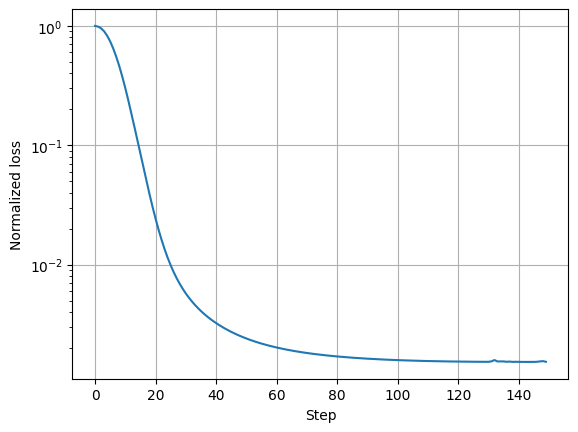

In [254]:
#|eval:false
range_ = trange(Nsteps)
losses = np.ndarray(Nsteps)
for step in range_:
    print("Step :", step+1, '/', Nsteps)
    loss, state = step_fn(step, state)
    losses[step] = loss
    range_.set_postfix(loss=float(loss))

plt.semilogy(np.arange(Nsteps), losses/np.max(losses));
plt.xlabel("Step")
plt.ylabel("Normalized loss")
plt.grid(True)

In [231]:
def loss_function(S):
    s11 = jnp.abs(S[:, 0, 0])**2
    s21 = jnp.abs(S[:, 0, 1])**2

    s = jnp.stack((s11,s21))
    g = jnp.stack((jnp.ones_like(s11),-jnp.ones_like(s21)))

    t_s21 = 10**(-0.5/20)
    t_s11 = 10**(-20/20)

    target = jnp.stack((jnp.ones_like(s11)*(t_s11**2),jnp.ones_like(s21)*(t_s21**2)))
    w_min = min(1-t_s21, t_s11)
    L = jnp.sum(jax.nn.softplus(g*(s-target)/w_min)**2)
    
    return L

In [232]:
s_test = jnp.zeros((1,1,2))
s11_paper = -18
s21_paper = -27

s_test = s_test.at[0,0,:].set(10 ** (jnp.array([s11_paper, s21_paper]) / 10))
loss_ini = loss_function(s_test)
print(loss_ini)

254.21458


In [233]:
s_test = jnp.zeros((1,1,2))
s11_paper = -50
s21_paper = -0.1

s_test = s_test.at[0,0,:].set(10 ** (jnp.array([s11_paper, s21_paper]) / 10))
loss_final = loss_function(s_test)
print(loss_final)

0.4464373


In [234]:
s_test = jnp.zeros((1,1,2))
s11_paper = -200
s21_paper = 0

s_test = s_test.at[0,0,:].set(10 ** (jnp.array([s11_paper, s21_paper]) / 10))
loss_final = loss_function(s_test)
print(loss_final)

0.38725692


In [235]:
print(loss_final / loss_ini, np.format_float_scientific(loss_final / loss_ini, exp_digits=1), np.log10(loss_final / loss_ini))

0.0015233465 1.5233465237542987e-3 -2.8172014


In [255]:
print(losses)

[254.74305725 251.51348877 243.39283752 229.73492432 211.2076416
 189.1756897  165.2809906  141.03013611 117.63607788  96.04902649
  76.94075012  60.66692734  47.26931381  36.53749084  28.11236954
  21.59044266  16.59385109  12.79877377   9.93812656   7.79487181
   6.1946764    4.99995899   4.10460615   3.42868114   2.91318655
   2.51521301   2.2037878    1.95664549   1.75773239   1.59542251
   1.46122432   1.34888506   1.25375891   1.17235076   1.10200834
   1.04069769   0.98684025   0.93919981   0.89679551   0.85884559
   0.82471371   0.79388177   0.76591974   0.74047214   0.7172395
   0.69596958   0.67644399   0.65847671   0.64190876   0.62659907
   0.61242616   0.5992834    0.58707416   0.57571673   0.56513596
   0.55526453   0.54604369   0.53742021   0.52934587   0.52177739
   0.51467592   0.50800502   0.50173306   0.49583119   0.49027222
   0.48503163   0.4800874    0.47541925   0.47100791   0.46683723
   0.46289012   0.45915222   0.45561099   0.4522534    0.44906801
   0.4460442

In [256]:
print(np.array(losses)/np.array(losses).max())

[1.         0.98732225 0.95544444 0.90182997 0.82910068 0.74261372
 0.64881451 0.55361719 0.46178325 0.37704276 0.30203277 0.23814948
 0.18555683 0.1434288  0.11035578 0.0847538  0.06513956 0.05024189
 0.03901235 0.03059896 0.02431735 0.01962746 0.01611273 0.01345937
 0.01143578 0.00987353 0.00865102 0.00768086 0.00690002 0.00626287
 0.00573607 0.00529508 0.00492166 0.00460209 0.00432596 0.00408528
 0.00387387 0.00368685 0.00352039 0.00337142 0.00323743 0.0031164
 0.00300664 0.00290674 0.00281554 0.00273205 0.0026554  0.00258487
 0.00251983 0.00245973 0.00240409 0.0023525  0.00230457 0.00225999
 0.00221845 0.0021797  0.00214351 0.00210966 0.00207796 0.00204825
 0.00202037 0.00199419 0.00196957 0.0019464  0.00192458 0.001904
 0.00188459 0.00186627 0.00184895 0.00183258 0.00181709 0.00180241
 0.00178851 0.00177533 0.00176283 0.00175096 0.00173968 0.00172897
 0.00171879 0.0017091  0.00169988 0.0016911  0.00168274 0.00167477
 0.00166718 0.00165993 0.00165303 0.00164644 0.00164014 0.0016341

In [155]:
val = np.array(losses/2)/np.array(losses).max()
np.format_float_scientific(val[-1], exp_digits=1)

'7.93550663252049e-4'

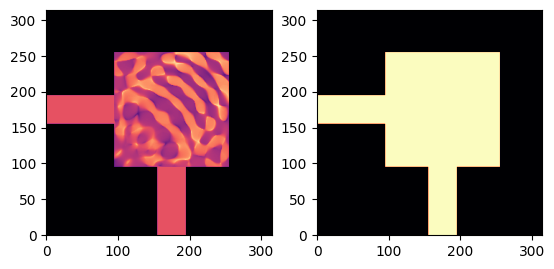

In [40]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(model.epsilon_r(params_fn(state)), origin='lower', cmap='magma')
ax[1].imshow(model.epsilon_r(forward(params_fn(state), brush)), origin='lower', cmap='magma')

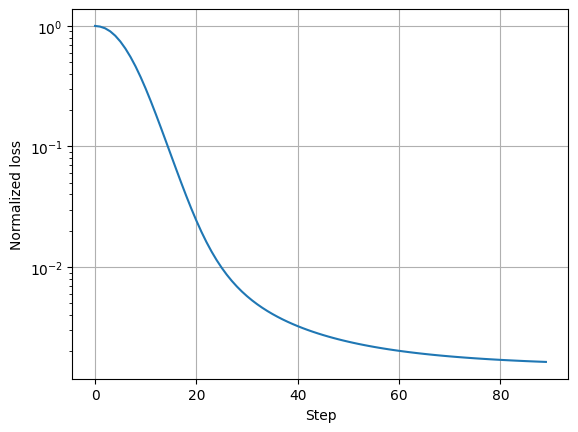

In [41]:
plt.semilogy(np.arange(Nsteps), losses/np.max(losses));
plt.xlabel("Step")
plt.ylabel("Normalized loss")
plt.grid(True)

In [17]:
plt.semilogy(np.arange(Nsteps), loss10/np.max(loss10), label="10**(-x/10)");
plt.semilogy(np.arange(Nsteps), loss20/np.max(loss20), label="10**(-x/20)");
plt.xlabel("Step")
plt.ylabel("Normalized loss")
plt.legend()
plt.grid(True)

NameError: name 'loss10' is not defined